
Solution template for the question 1.6-1.7. This template consists of following steps. Except the step 2, you don't need to modify it to answer the questions.
1.   Initialize libraries
2.   **Insert the answers for the questions 1.1~1.5 in q1_solution (this is the part you need to fill)**
3.   Define data loaders
4.   Define VAE network architecture
5.   Initialize the model and optimizer
6.   Train the model
7.   Save the model
8.   Load the model
9.   Evaluate the model with importance sampling

Initialize libraries

In [3]:
import math
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam

Complete **functions in q1_solution** to answer the questions 1.1~1.5

In [2]:
from q1_solution import log_likelihood_bernoulli, log_likelihood_normal, log_mean_exp, kl_gaussian_gaussian_analytic, kl_gaussian_gaussian_mc

Define data loaders

In [3]:
def get_data_loader(dataset_location, batch_size):
    URL = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/"
    # start processing
    def lines_to_np_array(lines):
        return np.array([[int(i) for i in line.split()] for line in lines])
    splitdata = []
    for splitname in ["train", "valid", "test"]:
        filename = "binarized_mnist_%s.amat" % splitname
        filepath = os.path.join(dataset_location, filename)
        utils.download_url(URL + filename, dataset_location)
        with open(filepath) as f:
            lines = f.readlines()
        x = lines_to_np_array(lines).astype('float32')
        x = x.reshape(x.shape[0], 1, 28, 28)
        # pytorch data loader
        dataset = data_utils.TensorDataset(torch.from_numpy(x))
        dataset_loader = data_utils.DataLoader(x, batch_size=batch_size, shuffle=splitname == "train")
        splitdata.append(dataset_loader)
    return splitdata

In [4]:
train, valid, test = get_data_loader("binarized_mnist", 64)

Using downloaded and verified file: binarized_mnist\binarized_mnist_train.amat
Using downloaded and verified file: binarized_mnist\binarized_mnist_valid.amat
Using downloaded and verified file: binarized_mnist\binarized_mnist_test.amat


Define VAE network architecture


In [17]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(784, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * latent_size),
        )

    def forward(self, x):
        batch_size = x.size(0)
        z_mean, z_logvar = self.mlp(x.view(batch_size, 784)).chunk(2, dim=-1)
        return z_mean, z_logvar

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_size, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784),
        )
        
    def forward(self, z):
        return self.mlp(z) - 5.

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.encode = Encoder(latent_size)
        self.decode = Decoder(latent_size)

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z_sample = z_mean + torch.exp(z_logvar / 2.) * torch.randn_like(z_logvar)
        x_mean = self.decode(z_sample)
        return z_mean, z_logvar, x_mean

    def loss(self, x, z_mean, z_logvar, x_mean):
        ZERO = torch.zeros(z_mean.size())
        kl = kl_gaussian_gaussian_mc(z_mean, z_logvar, ZERO, ZERO, num_samples=1000).mean()
        #kl = kl_gaussian_gaussian_analytic(z_mean, z_logvar, ZERO, ZERO).mean()
        recon_loss = -log_likelihood_bernoulli(
            torch.sigmoid(x_mean.view(x.size(0), -1)),
            x.view(x.size(0), -1),            
        ).mean()
        return recon_loss + kl

Initialize a model and optimizer

In [18]:
vae = VAE(100)
params = vae.parameters()
optimizer = Adam(params, lr=3e-4)
print(vae)

VAE(
  (encode): Encoder(
    (mlp): Sequential(
      (0): Linear(in_features=784, out_features=300, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=300, out_features=300, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=300, out_features=200, bias=True)
    )
  )
  (decode): Decoder(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=300, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=300, out_features=300, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=300, out_features=784, bias=True)
    )
  )
)


Train the model

In [19]:
ELBO = []

for i in range(20):
    # train
    for x in train:
        optimizer.zero_grad()
        z_mean, z_logvar, x_mean = vae(x)
        loss = vae.loss(x, z_mean, z_logvar, x_mean)
        loss.backward()
        optimizer.step()

    # evaluate ELBO on the valid dataset
    with torch.no_grad():
        total_loss = 0.
        total_count = 0
        for x in valid:
            total_loss += vae.loss(x, *vae(x)) * x.size(0)
            total_count += x.size(0)
        print('-elbo: ', (total_loss / total_count).item())
        ELBO.append((total_loss / total_count).item())

-elbo:  128.80972290039062
-elbo:  98.43050384521484
-elbo:  82.27193450927734
-elbo:  75.45198059082031
-elbo:  69.89994049072266
-elbo:  66.53399658203125
-elbo:  63.70643615722656
-elbo:  61.28762435913086
-elbo:  59.347354888916016
-elbo:  57.42560577392578
-elbo:  56.14753723144531
-elbo:  54.7750244140625
-elbo:  53.66975784301758
-elbo:  52.496456146240234
-elbo:  51.746116638183594
-elbo:  50.47117614746094
-elbo:  49.736473083496094
-elbo:  49.141422271728516
-elbo:  48.192081451416016
-elbo:  47.62504196166992


In [8]:
ELBO_analytic = ELBO

In [20]:
ELBO_mc = ELBO

In [21]:
import pandas as pd

df = pd.DataFrame(ELBO_analytic, ELBO_mc)

In [22]:
df.to_csv("ELBO.csv")

Save the model

In [23]:
torch.save(vae, 'model_1.pt')

Load the model

In [24]:
vae = torch.load('model_1.pt')

Evaluate the $\log p_\theta(x)$ of the model on test by using importance sampling

In [25]:
total_loss = 0.
total_count = 0
with torch.no_grad():
    #x = next(iter(test))
    for x in test:
        # init
        K = 200
        M = x.size(0)

        # Sample from the posterior
        z_mean, z_logvar = vae.encode(x)
        eps = torch.randn(z_mean.size(0), K, z_mean.size(1))
        z_samples = z_mean[:, None, :] + torch.exp(z_logvar / 2.)[:, None, :] * eps # Broadcast the noise over the mean and variance

        # Decode samples
        z_samples_flat = z_samples.view(-1, z_samples.size(-1)) # Flatten out the z samples
        x_mean_flat = vae.decode(z_samples_flat) # Push it through

        # Reshape images and posterior to evaluate probabilities
        x_flat = x[:, None].repeat(1, K, 1, 1, 1).reshape(M*K, -1)
        z_mean_flat = z_mean[:, None, :].expand_as(z_samples).reshape(M*K, -1)
        z_logvar_flat =  z_logvar[:, None, :].expand_as(z_samples).reshape(M*K, -1)
        ZEROS = torch.zeros(z_mean_flat.size())

        # Calculate all the probabilities!
        log_p_x_z = log_likelihood_bernoulli(torch.sigmoid(x_mean_flat), x_flat).view(M, K)
        log_q_z_x = log_likelihood_normal(z_mean_flat, z_logvar_flat, z_samples_flat).view(M, K)
        log_p_z = log_likelihood_normal(ZEROS, ZEROS, z_samples_flat).view(M, K)

        # Recombine them.
        w = log_p_x_z + log_p_z - log_q_z_x
        log_p = log_mean_exp(w)

        # Accumulate
        total_loss += log_p.sum()
        total_count += M

print('log p(x):', (total_loss / total_count).item())

log p(x): -292.06951904296875


In [ ]:
log_1 = -95.64202880859375
log_2 = -292.06951904296875

In [1]:
import pandas as pd

df = pd.read_csv("ELBO.csv")

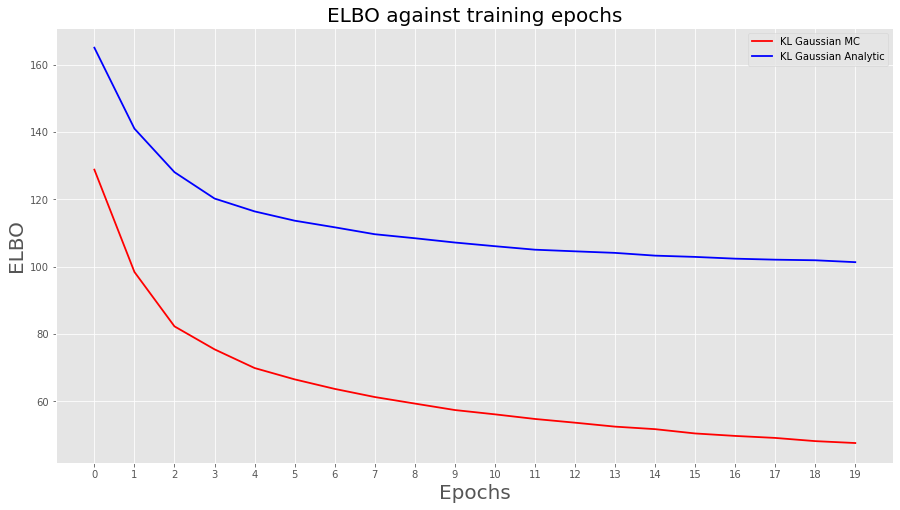

In [6]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize = (15, 8))
plt.style.use('ggplot')
plt.plot(range(20), df["Unnamed: 0"], color="red", label="KL Gaussian MC", linewidth=1.8)
plt.plot(range(20), df["0"], color="blue", label="KL Gaussian Analytic", linewidth=1.8)
plt.title("ELBO against training epochs", fontsize = 20)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("ELBO", fontsize=20)
plt.xticks(np.arange(min(range(20)), max(range(20))+1, 1.0))
plt.legend()